In [1]:
import matplotlib.pyplot as plt
import cython
%load_ext cython

# Arbitrary Additional Arguments

## Additional Args = Array of Doubles

In [2]:
%%cython --force 
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin

from CyRK.cy.cysolverNew cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType,MAX_STEP, CySolveOutput, PreEvalFunc

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, const void* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arguments are passed in as a void pointer to preallocated and instantiated memory. 
    # This memory could be stack or heap allocated. If it is not valid then you will run into seg faults.
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr = &y0_arr[0]
    
    # Define our arguments.
    cdef double[3] args_arr = [1.0, 1.0, 9.81]
    cdef double* args_dbl_ptr = &args_arr[0]

    # To work with cysolve_ivp, we must cast the args ptr to a void pointer
    cdef void* args_ptr = <void*>args_dbl_ptr

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_reg = run()
print("\n\nIntegration success =", result_reg.success, "\n\tNumber of adaptive time steps required:", result_reg.size)
print("Integration message:", result_reg.message)

Content of stdout:
_cython_magic_8d0ede78cc112eb23d23a241f47f9fb4114482cf.cpp
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(336): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(341): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(350): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\.ipython\cython\_cython_magic_8d0ede78cc112eb23d23a241f47f9fb4114482cf.cpp(25111): warning C4551: function call missing argument list
   Creati

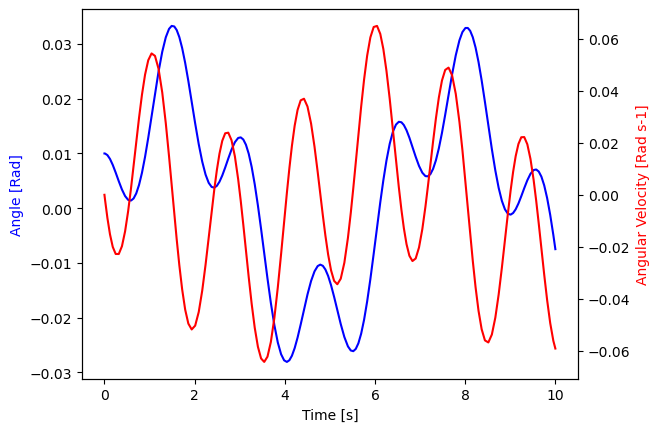

In [3]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_reg.t, result_reg.y[0], c='b')
ax2.plot(result_reg.t, result_reg.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

## Additional Args = Cython C-Struct

In [6]:
%%cython --force 
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin
from libcpp cimport bool as cpp_bool

from CyRK.cy.cysolverNew cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType,MAX_STEP, CySolveOutput, PreEvalFunc

cdef struct PendulumArgs:
    # Structure that contains heterogeneous types
    cpp_bool use_drag
    double g
    double l
    double m

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, const void* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arg pointer still must be listed as a void pointer or it will not work with cysolve_ivp.
    # But now the user can recast that void pointer to the structure they wish.
    cdef PendulumArgs* pendulum_args_ptr = <PendulumArgs*>args_ptr
    # And easily access its members which can be many heterogeneous types.
    cdef double l = pendulum_args_ptr.l
    cdef double m = pendulum_args_ptr.m
    cdef double g = pendulum_args_ptr.g
    cdef double use_drag = pendulum_args_ptr.use_drag

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque

    if use_drag:
        dy_ptr[1] -= 1.5 * y1

# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr = &y0_arr[0]
    
    # Define our arguments.
    # We now have a a structure that we need to allocate memory for.
    # For this example, let's do it on the stack. 
    cdef PendulumArgs pendulum_args = PendulumArgs(True, 9.81, 1.0, 1.0)
    # We need to pass in a void pointer to cysolve_ivp, so let's cast the address of the struct to void*
    cdef void* args_ptr = <void*>&pendulum_args

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_drag = run()
print("\n\nIntegration success =", result_drag.success, "\n\tNumber of adaptive time steps required:", result_drag.size)
print("Integration message:", result_drag.message)

Content of stdout:
_cython_magic_e6262dcd87a259499b282df2dbe405a97fe5a589.cpp
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(336): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(341): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(350): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\.ipython\cython\_cython_magic_e6262dcd87a259499b282df2dbe405a97fe5a589.cpp(25182): warning C4551: function call missing argument list
   Creati

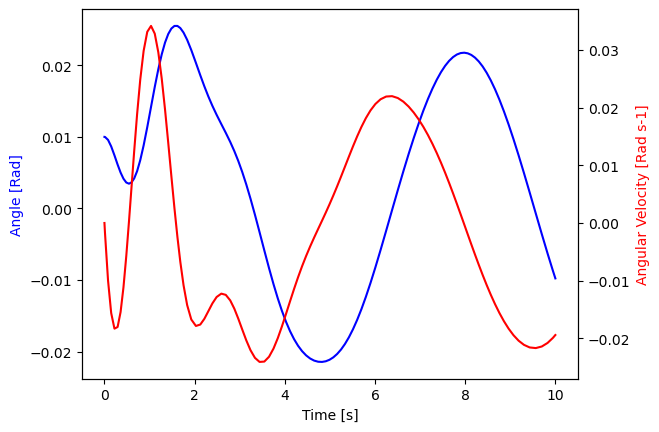

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_drag.t, result_drag.y[0], c='b')
ax2.plot(result_drag.t, result_drag.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

# Pre-Evaluation Functions

In [16]:
%%cython --force 
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin

from CyRK.cy.cysolverNew cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType,MAX_STEP, CySolveOutput, PreEvalFunc

cdef void pendulum_preeval_func(void* output_ptr, double time, double* y_ptr, const void* args_ptr) noexcept nogil:
    # Unpack args
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double torque

    # External torque
    torque = 0.1 * sin(time)

    # Convert output pointer to double pointer so we can store data
    cdef double* output_dbl_ptr = <double*>output_ptr
    output_dbl_ptr[0] = torque
    output_dbl_ptr[1] = coeff_1
    output_dbl_ptr[2] = coeff_2


cdef void pendulum_preeval_diffeq(double* dy_ptr, double t, double* y_ptr, const void* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    
    # Make stack allocated storage for pre eval output
    cdef double[3] pre_eval_storage
    cdef double* pre_eval_storage_ptr = &pre_eval_storage[0]

    # Cast storage to void so we can call function
    cdef void* pre_eval_storage_void_ptr = <void*>pre_eval_storage_ptr

    # Call Pre-Eval Function
    pre_eval_func(pre_eval_storage_void_ptr, t, y_ptr, args_ptr)

    cdef double y0 = y_ptr[0]
    cdef double y1 = y_ptr[1]

    # Use results of pre-eval function to update dy. Note that we are using the double* not the void* here.
    # Even though pre_eval_func was passed the void* it updated the memory that the double* pointed to so we can use it below.
    dy_ptr[0] = y1
    dy_ptr[1] = pre_eval_storage_ptr[1] * sin(y0) + pre_eval_storage_ptr[2] * pre_eval_storage_ptr[0]


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_preeval_diffeq
    
    # Setup pointer to pre-eval function
    cdef PreEvalFunc pre_eval_func = pendulum_preeval_func
    
    # Define time domain
    cdef double[2] time_span_arr = [0.0, 10.0]
    cdef double* t_span_ptr = &time_span_arr[0]
    
    # Define initial conditions
    cdef double[2] y0_arr = [0.01, 0.0]
    cdef double* y0_ptr = &y0_arr[0]
    
    # Define our arguments.
    cdef double[3] args_arr = [1.0, 1.0, 9.81]
    cdef double* args_dbl_ptr = &args_arr[0]

    # To work with cysolve_ivp, we must cast the args ptr to a void pointer
    cdef void* args_ptr = <void*>args_dbl_ptr

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        2,  # Number of dependent variables
        method = 1, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_ptr = args_ptr,
        num_extra = 0,
        max_num_steps = 100_000_000,
        max_ram_MB = 2000,
        dense_output = False,
        t_eval = NULL,
        len_t_eval = 0,
        pre_eval_func = pre_eval_func
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result

result_preeval = run()
print("\n\nIntegration success =", result_preeval.success, "\n\tNumber of adaptive time steps required:", result_preeval.size)
print("Integration message:", result_preeval.message)

Content of stdout:
_cython_magic_9167236c37967ff7fe4e4a41a0fab0ad22776efe.cpp
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(336): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(341): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\AppData\Local\anaconda3\envs\dev311\Lib\site-packages\CyRK\cy\cysolver.cpp(350): warning C4244: '=': conversion from '__int64' to 'int', possible loss of data
C:\Users\jrenaud\.ipython\cython\_cython_magic_9167236c37967ff7fe4e4a41a0fab0ad22776efe.cpp(25223): warning C4551: function call missing argument list
   Creati

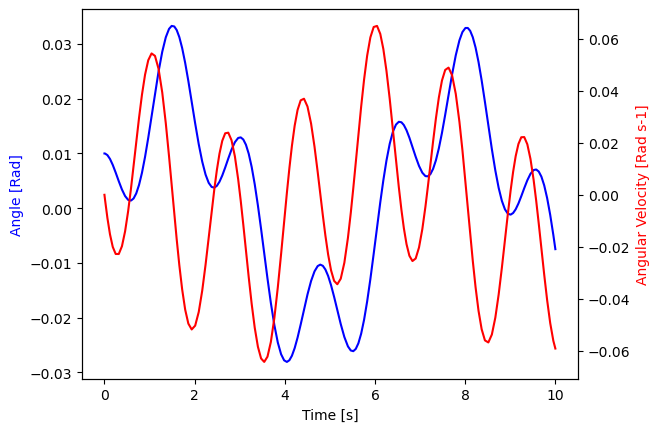

In [17]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_preeval.t, result_preeval.y[0], c='b')
ax2.plot(result_preeval.t, result_preeval.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()